 **Data Science Engineering Methods and Tools**

**Assignment 2 - Kaggle Competition - Homesite Quote Conversion**

**Name : Divya Unnikrishnan**

**NUID: 001001182**

**Abstract**

The goal of Homesite Quote Conversion competition is to predict which which customers will purchase a given insurance quote. We have been given an anonymized dataset which has information on customer and sales activity, including property and coverage information. Each QuoteNumber corresponds to a potential customer and the QuoteConversion_Flag indicates whether the customer purchased a policy. The training dataset consists of around 260,000 rows and around 300 features, a mixture of numeric and categorical. This solution focuses on Gradient Boosting Classifier with and without hyperparameter tuning.  A metric score calculation function has been created which measures the area under the ROC curve


**Using Kaggle API to import CSV file from the competition**

In [57]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [58]:
!kaggle competitions download -c "homesite-quote-conversion"

train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [59]:
! unzip train.csv.zip -d train
! unzip test.csv.zip -d test

Archive:  train.csv.zip
replace train/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  test.csv.zip
replace test/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


**Importing necessary Python libraries**

In [60]:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#importing necessary Python libraries
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


# Set the aesthetic style of the plots.
sns.set_style(style='darkgrid')
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Printing first 5 rows of the training csv

In [61]:
housing_df_train=pd.read_csv("train/train.csv")
housing_df_train.head(5)

,QuoteNumber,Original_Quote_Date,QuoteConversion_Flag,Field6,Field7,Field8,Field9,Field10,Field11,Field12,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,CoverageField3B,CoverageField4A,CoverageField4B,CoverageField5A,CoverageField5B,CoverageField6A,CoverageField6B,CoverageField8,CoverageField9,CoverageField11A,CoverageField11B,SalesField1A,SalesField1B,SalesField2A,SalesField2B,SalesField3,SalesField4,SalesField5,SalesField6,SalesField7,SalesField8,SalesField9,SalesField10,SalesField11,SalesField12,...,GeographicField44A,GeographicField44B,GeographicField45A,GeographicField45B,GeographicField46A,GeographicField46B,GeographicField47A,GeographicField47B,GeographicField48A,GeographicField48B,GeographicField49A,GeographicField49B,GeographicField50A,GeographicField50B,GeographicField51A,GeographicField51B,GeographicField52A,GeographicField52B,GeographicField53A,GeographicField53B,GeographicField54A,GeographicField54B,GeographicField55A,GeographicField55B,GeographicField56A,GeographicField56B,GeographicField57A,GeographicField57B,GeographicField58A,GeographicField58B,GeographicField59A,GeographicField59B,GeographicField60A,GeographicField60B,GeographicField61A,GeographicField61B,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64
0,1,2013-08-16,0,B,23,0.9403,0.0006,965,1.0200,N,17,23,17,23,15,22,16,22,13,22,13,23,T,D,2,1,7,18,3,8,0,5,5,24,V,48649,0,0,0,0,...,8,4,20,22,10,8,6,5,15,13,19,18,16,14,21,23,21,23,16,11,22,24,7,14,-1,17,15,17,14,18,9,9,-1,8,-1,18,-1,10,N,CA
1,2,2014-04-22,0,F,7,1.0006,0.0040,548,1.2433,N,6,8,6,8,5,7,5,8,13,22,13,23,T,E,5,9,5,14,6,18,1,5,5,11,P,26778,0,0,1,1,...,23,24,11,15,21,24,6,11,21,21,18,15,20,20,13,12,12,12,15,9,13,11,11,20,-1,9,18,21,8,7,10,10,-1,11,-1,17,-1,20,N,NJ
2,4,2014-08-25,0,F,7,1.0006,0.0040,548,1.2433,N,7,12,7,12,6,10,7,11,25,25,13,23,T,J,4,6,3,10,4,11,1,5,5,11,K,8751,0,0,2,2,...,21,22,24,25,20,22,7,13,23,23,20,19,20,20,18,20,19,21,20,19,11,8,3,3,-1,5,21,24,12,15,15,18,-1,21,-1,11,-1,8,N,NJ
3,6,2013-04-15,0,J,10,0.9769,0.0004,"1,165",1.2665,N,3,2,3,2,2,2,3,2,13,22,13,23,Y,F,15,23,8,19,14,24,0,5,5,23,V,43854,0,0,0,0,...,3,1,14,22,6,2,7,14,11,8,19,18,18,16,13,12,13,12,17,13,5,2,3,4,-1,7,14,14,14,18,6,5,-1,10,-1,9,-1,21,N,TX
4,8,2014-01-25,0,E,23,0.9472,0.0006,"1,487",1.3045,N,8,13,8,13,7,11,7,13,13,22,13,23,T,F,4,6,3,6,3,6,1,5,5,7,R,12505,1,0,0,0,...,24,25,9,11,25,25,5,3,22,22,21,21,17,15,25,25,25,25,17,13,13,11,3,4,-1,7,11,9,10,10,18,22,-1,10,-1,11,-1,12,N,IL


Printing first 5 rows of the testing csv

In [62]:
housing_df_test=pd.read_csv("test/test.csv")
housing_df_test.head(5)

,QuoteNumber,Original_Quote_Date,Field6,Field7,Field8,Field9,Field10,Field11,Field12,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,CoverageField3B,CoverageField4A,CoverageField4B,CoverageField5A,CoverageField5B,CoverageField6A,CoverageField6B,CoverageField8,CoverageField9,CoverageField11A,CoverageField11B,SalesField1A,SalesField1B,SalesField2A,SalesField2B,SalesField3,SalesField4,SalesField5,SalesField6,SalesField7,SalesField8,SalesField9,SalesField10,SalesField11,SalesField12,SalesField13,...,GeographicField44A,GeographicField44B,GeographicField45A,GeographicField45B,GeographicField46A,GeographicField46B,GeographicField47A,GeographicField47B,GeographicField48A,GeographicField48B,GeographicField49A,GeographicField49B,GeographicField50A,GeographicField50B,GeographicField51A,GeographicField51B,GeographicField52A,GeographicField52B,GeographicField53A,GeographicField53B,GeographicField54A,GeographicField54B,GeographicField55A,GeographicField55B,GeographicField56A,GeographicField56B,GeographicField57A,GeographicField57B,GeographicField58A,GeographicField58B,GeographicField59A,GeographicField59B,GeographicField60A,GeographicField60B,GeographicField61A,GeographicField61B,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64
0,3,2014-08-12,E,16,0.9364,0.0006,"1,487",1.3045,N,4,4,4,4,3,3,3,4,13,22,13,23,Y,K,13,22,6,16,9,21,0,5,5,11,P,67052,0,0,0,0,0,...,22,23,9,12,25,25,6,9,4,2,16,12,20,20,2,2,2,1,1,1,10,7,25,25,-1,19,19,22,12,15,1,1,-1,1,-1,20,-1,25,Y,IL
1,5,2013-09-07,F,11,0.9919,0.0038,564,1.1886,N,8,14,8,14,7,12,8,13,13,22,13,23,T,E,4,5,3,6,3,6,1,5,5,4,R,27288,1,0,0,0,0,...,23,24,12,21,23,25,7,11,16,14,13,6,17,15,7,5,7,5,13,7,14,14,7,14,-1,4,1,1,5,3,10,10,-1,5,-1,5,-1,21,N,NJ
2,7,2013-03-29,F,15,0.8945,0.0038,564,1.0670,N,11,18,11,18,10,16,10,18,13,22,13,23,T,E,3,3,5,14,3,9,1,5,5,23,V,65264,0,1,2,2,0,...,16,18,9,10,14,16,6,8,20,19,17,14,16,13,20,22,20,22,20,18,10,7,4,7,-1,11,13,12,18,22,10,11,-1,20,-1,22,-1,11,N,NJ
3,9,2015-03-21,K,21,0.8870,0.0004,"1,113",1.2665,Y,14,22,15,22,13,20,22,25,13,22,13,23,Y,F,5,9,9,20,5,16,1,5,5,11,R,32725,1,1,1,1,0,...,11,11,9,10,11,13,15,21,14,12,17,13,10,6,20,22,20,22,19,16,12,11,4,6,-1,13,10,8,5,3,8,8,-1,13,-1,8,-1,21,N,TX
4,10,2014-12-10,B,25,0.9153,0.0007,935,1.0200,N,4,5,4,5,4,4,4,5,13,22,13,23,Y,D,12,21,1,1,3,6,0,5,5,11,T,56025,0,1,1,1,0,...,9,8,25,25,9,3,9,18,7,4,16,12,13,9,8,6,8,6,11,5,19,21,13,21,-1,23,11,8,5,3,7,7,-1,3,-1,22,-1,21,N,CA


**Calculating percentage of null values in the columns**

In [63]:
null_counts = housing_df_train.isnull().sum()
null_counts[null_counts>0]* 100 / len(housing_df_train)

PersonalField7      0.043336
PersonalField84    47.634351
PropertyField3      0.031064
PropertyField4      0.024161
PropertyField29    76.963640
PropertyField32     0.026845
PropertyField34     0.026845
PropertyField36     0.043336
PropertyField38     0.467876
dtype: float64

In [87]:
null_counts = housing_df_test.isnull().sum()
null_counts[null_counts>0]* 100 / len(housing_df_test)

Series([], dtype: float64)

**Dropping columns with null values**

In [65]:
housing_df_train.drop(['PropertyField29','PersonalField84'], axis=1, inplace=True)

In [66]:
housing_df_test.drop(['PropertyField29','PersonalField84'], axis=1, inplace=True)

**Feature Engineering**

**Converting the Quote date column into Dates and then extracting the month, date, day & year**

In [67]:
housing_df_train['Date'] = pd.to_datetime(pd.Series(housing_df_train['Original_Quote_Date']))

# Drop 'Original_Quote_date'
housing_df_train = housing_df_train.drop('Original_Quote_Date', axis=1)

# Extract year,month,weekday from 'Date'
housing_df_train['Year'] = housing_df_train['Date'].apply(lambda x: x.year)
housing_df_train['Month'] = housing_df_train['Date'].apply(lambda x: x.month)
housing_df_train['weekday'] = housing_df_train['Date'].apply(lambda x: x.weekday())
housing_df_train=housing_df_train.drop('Date', axis=1)

In [68]:
housing_df_test['Date'] = pd.to_datetime(pd.Series(housing_df_test['Original_Quote_Date']))

# Drop 'Original_Quote_date'
housing_df_test = housing_df_test.drop('Original_Quote_Date', axis=1)

# Extract year,month,weekday from 'Date'
housing_df_test['Year'] = housing_df_test['Date'].apply(lambda x: x.year)
housing_df_test['Month'] = housing_df_test['Date'].apply(lambda x: x.month)
housing_df_test['weekday'] = housing_df_test['Date'].apply(lambda x: x.weekday())
housing_df_test=housing_df_test.drop('Date', axis=1)

**Imputing null values of the column**


In [69]:
housing_df_train = housing_df_train.fillna(-1)
housing_df_test = housing_df_test.fillna(-1)


**Encoding categorical Features**

In [70]:
for f in housing_df_train.columns:
    if housing_df_train[f].dtype=='object':
        print(f)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(housing_df_train[f].values) + list(housing_df_test[f].values))
        housing_df_train[f] = lbl.transform(list(housing_df_train[f].values))
        housing_df_test[f] = lbl.transform(list(housing_df_test[f].values))

Field6
Field10
Field12
CoverageField8
CoverageField9
SalesField7
PersonalField7
PersonalField16
PersonalField17
PersonalField18
PersonalField19
PropertyField3
PropertyField4
PropertyField5
PropertyField7
PropertyField14
PropertyField28
PropertyField30
PropertyField31
PropertyField32
PropertyField33
PropertyField34
PropertyField36
PropertyField37
PropertyField38
GeographicField63
GeographicField64


**Insight**
 - Some of the columns in the dataset has 'object' data type indicating categorical values.
 - Encoding categorical columns to integer type values

**Extracting target variable and train set**

In [71]:
y=housing_df_train['QuoteConversion_Flag']
X = housing_df_train.drop(['QuoteConversion_Flag'], axis=1)

**Splitting the training data into train and eval sets**

In [72]:

X_train,X_eval,y_train,y_eval=train_test_split(X,y,test_size=0.30,random_state=1,stratify=y)

- Insights
- Since the training dataset has a large number of values, it has been split in the ratio of 70:30 as training and eval datasets for better time complexity 


**Function to calculate metric scores of the model**

In [73]:
def get_roc_auc_score(model, flag=True):
    '''
    model : classifier to predict values of X

    '''
    c = []
    pred_train = model.predict(X_train)
    
    train_rec = metrics.roc_auc_score(y_train,pred_train)
    c.append(train_rec) # adding train recall to list
    if flag == True:
        print("ROC_AUC_Score on training set : ", train_rec)
        
    return c 

**Creating the model**

**Gradient Boosting Model**

In [74]:
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

**Fitting Gradient Boosting on training dataset **

In [ ]:
gb_classifier = GradientBoostingClassifier(random_state=1)
gb_classifier.fit(X_train,y_train)

Calculating ROC AUC Matrix

In [23]:
get_roc_auc_score(gb_classifier)

ROC_AUC_Score on training set :  0.8123037366655376


[0.8123037366655376]

After creating the model with default parameters we are getting an ROC_AUC score of 0.8123037366655376 which is less. We will find out if the accuracy increases after doing hyperparameter tuning

In [25]:
! unzip sample_submission.csv.zip -d submission

Archive:  sample_submission.csv.zip
  inflating: submission/sample_submission.csv  


**Creating Kaggle Submission File**

In [27]:
output_submission = pd.DataFrame(zip(housing_df_test.QuoteNumber,gb_classifier.predict_proba(housing_df_test)[:,1]), columns = ['QuoteNumber','QuoteConversion_Flag'])
output_submission.to_csv('gradientboosting.csv', index=False)

**Hyperparameter Tuning**

In [76]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier


**Grid of parameters to choose from**

In [77]:
param_grid={ 'subsample': [.9],"max_depth": [6]}

**Choosing the type of Classifier**

In [78]:
gb_classifier_tuned = GradientBoostingClassifier(random_state=1)

**Run the grid search**

In [79]:
grid_obj=GridSearchCV(gb_classifier_tuned, param_grid, scoring='roc_auc',cv=5)

The GridSearchCV is being run on the eval dataset. This will reduce the time taken to fit the model as the eval data set has less number of values

In [39]:
grid_obj = grid_obj.fit(X_eval, y_eval)

Set the clf to the best combination of parameters

In [40]:
gbc_tuned = grid_obj.best_estimator_

Fit the best algorithm to the training data.

In [80]:
gbc_tuned.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=6,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=0.9, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Find the scoring metric

In [42]:
get_roc_auc_score(gbc_tuned)

ROC_AUC_Score on training set :  0.8464083361066608


[0.8464083361066608]

**Implementing SHAP **

In [83]:
!pip install shap
import shap

     |████████████████████████████████| 371 kB 5.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509237 sha256=6d3572dc2bb3f8649e785996fc24a6eb91a03f242f141ab90c66c3a783c9c7f3
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [86]:
import shap

shap_values = shap.TreeExplainer(gbc_tuned).shap_values(X_train)


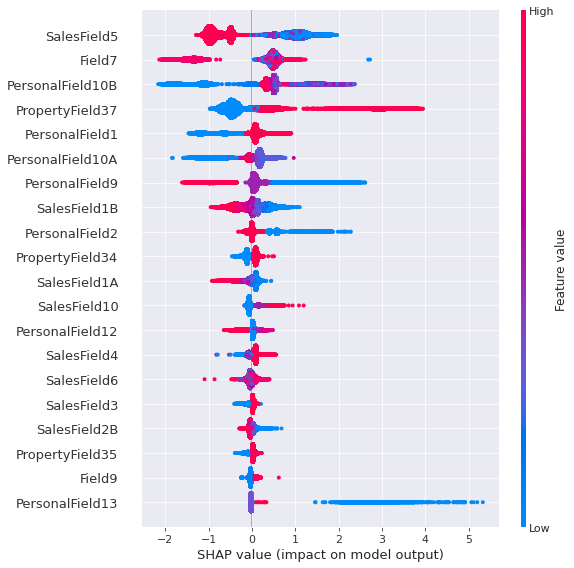

In [85]:
shap.summary_plot(shap_values, X_train)

**Insights**
- From the above graph of SHAP Values, we can infer that PropertyField37 has the highest importance to the model. 
- The next best feature would be SalesField5
-The fields which have are more towards blue color are less important to the model

**Creating submission file for Kaggle**

In [43]:
output_submission = pd.DataFrame(zip(housing_df_test.QuoteNumber,gbc_tuned.predict_proba(housing_df_test)[:,1]), columns = ['QuoteNumber','QuoteConversion_Flag'])
output_submission.to_csv('gradientboosting_hyperparametertuning.csv', index=False)

**Contributition**

The implementation of Gradient Boosting was not previously done by other Kaggle Contributors. The GB model gave a public score of 0.95909 and a score of 0.96406 after doing hyperparameter tuning

**References**

1. https://www.kaggle.com/c/homesite-quote-conversion/overview
2. Scikit learn official documentation.
3. Refered towardsdatascience

**Kaggle** has been used to take the competition. Algorithms have been refered from **Sckit learn official documentation** and also from the notebook avaialable on Kaggle. Exploratory data analysis has been referred from **towardsdatascience**. The rest of the code has been done independently.

**Licencing**

Copyright 2021 Divya Unnikrishnan

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.